In [0]:
# Link: https://github.com/matthew-liu/beta-vae/blob/master/preprocess.py

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -q "/content/drive/My Drive/CelebA.zip" 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import torch,os,cv2,csv
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import time
from skimage import io, transform
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.nn import Linear, ReLU,Tanh, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None): 
        self.attributes_frame = pd.read_csv(csv_file,delimiter=' ')
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.attributes_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.attributes_frame.iloc[idx, 0])
        image = io.imread(img_name)
        image = cv2.resize(image,(64,64))
        attributes = self.attributes_frame.loc[idx, ['Male','Eyeglasses','Smiling']]
        attributes = np.array([attributes])
        attributes = attributes.astype('float').reshape(-1, 1)
        sample = {'image': image, 'attributes': attributes}
        if self.transform:
            sample = self.transform(sample)
        return sample
class ToTensor(object):
    def __call__(self, sample):
        image, attributes = sample['image'], sample['attributes']
        norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        im = torch.from_numpy(norm_image).float()
        ln = torch.from_numpy(attributes).float()
        return {'image':im,
                'attributes':ln }

In [4]:
data = pd.read_csv('/content/processed_file.txt',delimiter=' ')

data.loc[907, ['image_name','Male','Eyeglasses','Smiling']]


image_name    000908.jpg
Male                   1
Eyeglasses            -1
Smiling               -1
Name: 907, dtype: object

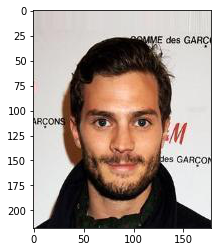

In [5]:
image = io.imread('/content/img_align_celeba'+'/000908.jpg')
plt.imshow(image)

In [0]:
imgpath = '/content/img_align_celeba'
attrfile = '/content/processed_file.txt'
BATCH_SIZE = 64

dataset = CustomDataset(csv_file=attrfile,root_dir=imgpath,transform=transforms.Compose([
                                               ToTensor()
                                           ]))

validation_split = .006
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_iterator = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)
test_iterator = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                sampler=valid_sampler)

In [7]:
print(len(test_iterator))

for i, sample in enumerate(test_iterator):
  print(sample['image'].shape,sample['attributes'].shape)
  break
  
# print(len(test_iterator))

19
torch.Size([64, 64, 64, 3]) torch.Size([64, 3, 1])


In [0]:
# CelebA (VAE)
# Input 64x64x3.
# Adam 1e-4
# Encoder Conv 32x4x4 (stride 2), 32x4x4 (stride 2), 64x4x4 (stride 2),
# 64x4x4 (stride 2), FC 256. ReLU activation.
# Latents 32
# Decoder Deconv reverse of encoder. ReLU activation. Gaussian.

class BetaVAE(nn.Module):

    def __init__(self, latent_size=32, beta=1):
        super(BetaVAE, self).__init__()

        self.latent_size = latent_size
        self.beta = beta

        # encoder
        self.encoder = nn.Sequential(
            self._conv(3, 32),
            self._conv(32, 32),
            self._conv(32, 64),
            self._conv(64, 64),
        )
        self.fc_mu = nn.Linear(256, latent_size)
        self.fc_var = nn.Linear(256, latent_size)

        # decoder
        self.decoder = nn.Sequential(
            self._deconv(64, 64),
            self._deconv(64, 32),
            self._deconv(32, 32, 1),
            self._deconv(32, 3),
            nn.Sigmoid()
        )
        self.fc_z = nn.Linear(latent_size, 256)

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 256)
        return self.fc_mu(x), self.fc_var(x)

    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # e^(1/2 * log(std^2))
        eps = torch.randn_like(std)  # random ~ N(0, 1)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        z = self.fc_z(z)
        z = z.view(-1, 64, 2, 2)
        return self.decoder(z)

    def forward(self, x):
        # print(x.shape)
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        rx = self.decode(z)
        return rx, mu, logvar

    def _conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels,
                kernel_size=4, stride=2
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    # out_padding is used to ensure output size matches EXACTLY of conv2d;
    # it does not actually add zero-padding to output :)
    def _deconv(self, in_channels, out_channels, out_padding=0):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels,
                kernel_size=4, stride=2, output_padding=out_padding
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def loss(self, recon_x, x, mu, logvar):
        # reconstruction losses are summed over all elements and batch
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        kl_diverge = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return (recon_loss + self.beta * kl_diverge) / x.shape[0]  # divide total loss by batch size

    def save_model(self, file_path, num_to_keep=1):
        utils.save(self, file_path, num_to_keep)

    def load_model(self, file_path):
        utils.restore(self, file_path)

    def load_last_model(self, dir_path):
        return utils.restore_latest(self, dir_path)


class DFCVAE(BetaVAE):

    def __init__(self, latent_size=100, beta=1):
        super(DFCVAE, self).__init__()

        self.latent_size = latent_size
        self.beta = beta

        # encoder
        self.e1 = self._conv(3, 32)
        self.e2 = self._conv(32, 64)
        self.e3 = self._conv(64, 128)
        self.e4 = self._conv(128, 256)
        self.fc_mu = nn.Linear(4099, latent_size)
        self.fc_var = nn.Linear(4099, latent_size)

        # decoder
        self.d1 = self._upconv(256, 128)
        self.d2 = self._upconv(128, 64)
        self.d3 = self._upconv(64, 32)
        self.d4 = self._upconv(32, 3)
        # Here 3 is number of attribute
        # self.fc_zc = nn.Linear(latent_size,97)
        self.fc_z = nn.Linear(latent_size+3, 4096)

    def encode(self, x,y):
        
        x = F.leaky_relu(self.e1(x))
        x = F.leaky_relu(self.e2(x))
        x = F.leaky_relu(self.e3(x))
        x = F.leaky_relu(self.e4(x))
        x = x.view(-1, 4096)
        x = torch.cat([x,y],1)
        # print(x.shape)
        return self.fc_mu(x), self.fc_var(x)

    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # e^(1/2 * log(std^2))
        eps = torch.randn_like(std)  # random ~ N(0, 1)
        return eps.mul(std).add_(mu)

    def decode(self, z,y):
        # print("Decode ",z.shape,y.shape)
        # z = self.fc_zc(z)
        z = torch.cat([z,y],1)
        z = self.fc_z(z)
        z = z.view(-1, 256, 4, 4)
        z = F.leaky_relu(self.d1(F.interpolate(z, scale_factor=2)))
        z = F.leaky_relu(self.d2(F.interpolate(z, scale_factor=2)))
        z = F.leaky_relu(self.d3(F.interpolate(z, scale_factor=2)))
        z = F.leaky_relu(self.d4(F.interpolate(z, scale_factor=2)))
        return torch.sigmoid(z)

    def forward(self, x,y):
      # print(x.shape)
        mu, logvar = self.encode(x,y)
        # print(mu.shape,logvar.shape)
        z = self.sample(mu, logvar)
        rx = self.decode(z,y)
        return rx, mu, logvar

    def _conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(out_channels),
        )

    def _upconv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(
                in_channels, out_channels,
                kernel_size=3, stride=1
            ),
            nn.BatchNorm2d(out_channels),
        )

In [0]:
def concat_tile(im_list_2d):
    return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])

def plot_each_iterate(original_images,rect_images,epoch):
  path = '/content/save_image/'
  # plt.figure(figsize=(10,5))
  # for i in range(5):
  #   plt.subplot(2,5,i+1)
  #   plt.imshow(original_images[i])
  #   plt.subplot(2,5,i+6)
  #   plt.imshow(rect_images[i])

  for i in range(len(original_images)):
    original_images[i] = cv2.cvtColor(original_images[i].numpy()*255 ,cv2.COLOR_BGR2RGB)
    rect_images[i] = cv2.cvtColor(rect_images[i].numpy()*255 ,cv2.COLOR_BGR2RGB)
   
  im_tile = concat_tile([original_images,rect_images])
  cv2.imwrite(path+str(epoch)+'.jpg', im_tile)  

In [0]:
EPOCHS = 10
LATENT_SIZE = 100
LEARNING_RATE = 1e-4
PRINT_INTERVAL = 100
model = DFCVAE(latent_size=LATENT_SIZE).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [0]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    train_loss = 0

    for batch_idx, sample in enumerate(train_iterator):
        data,y = sample['image'].to(device),sample['attributes'].to(device)
        data = data.view((-1,3,64,64))
        y = y.view(-1,3)
        # print(data.shape,y.shape)
        optimizer.zero_grad()
        output, mu, logvar = model(data,y)
        loss = model.loss(output, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()), epoch, batch_idx * len(data),
                len(train_iterator.dataset), 100. * batch_idx / len(train_iterator), loss.item()))
    train_loss /= len(train_iterator)
    print('Train set Average loss:', train_loss)
    return train_loss

In [0]:

def test(model, device, test_loader,epoch):
    original_images,rect_images = [],[]
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data,y = sample['image'].to(device),sample['attributes'].to(device)
            data = data.view((-1,3,64,64))
            y = y.view(-1,3)
            # l,m=[],[-1,-1,1]
            # for i in range(256):
            #   l.append(m)
            # p = np.array(l).reshape(256,3)
            # p = torch.from_numpy(p).float().to(device)
            # p = p.view(-1,3)
            # print(y.shape,p.shape)
            output, mu, logvar = model(data,y)     
            loss = model.loss(output, data, mu, logvar)
            test_loss += loss.item()
            original_images.append(data[0].view((64,64,3)).cpu())
            rect_images.append(output[0].view((64,64,3)).cpu())
            if batch_idx == 4:
              plot_each_iterate(original_images,rect_images,epoch)
              break

    test_loss /= len(test_loader)
    print('Test set Average loss:', test_loss)

In [0]:
# test(model, device, test_iterator,1)/content/0005.pt

In [0]:
MODEL_PATH = '/content/save_model/'
# model = torch.load('/content/save_model/0019.pt')

for epoch in range(0,20):
        train_loss = train(model, device, train_iterator, optimizer, epoch, PRINT_INTERVAL)
        test(model, device, test_iterator,epoch)
        file_name = ('%04d.pt' % epoch)
        torch.save(model, MODEL_PATH+file_name)
        

Mon Mar  9 07:13:16 2020 Train Epoch: 0 [0/202599 (0%)]	Loss: 8458.526367
Mon Mar  9 07:13:40 2020 Train Epoch: 0 [6400/202599 (3%)]	Loss: 8189.439941
Mon Mar  9 07:14:04 2020 Train Epoch: 0 [12800/202599 (6%)]	Loss: 8059.328125
Mon Mar  9 07:14:28 2020 Train Epoch: 0 [19200/202599 (10%)]	Loss: 8039.670898
Mon Mar  9 07:14:52 2020 Train Epoch: 0 [25600/202599 (13%)]	Loss: 8095.002441
Mon Mar  9 07:15:16 2020 Train Epoch: 0 [32000/202599 (16%)]	Loss: 8067.032227
Mon Mar  9 07:15:40 2020 Train Epoch: 0 [38400/202599 (19%)]	Loss: 7893.190430
Mon Mar  9 07:16:04 2020 Train Epoch: 0 [44800/202599 (22%)]	Loss: 7923.895996
Mon Mar  9 07:16:28 2020 Train Epoch: 0 [51200/202599 (25%)]	Loss: 8049.779297
Mon Mar  9 07:16:52 2020 Train Epoch: 0 [57600/202599 (29%)]	Loss: 7882.742676
Mon Mar  9 07:17:16 2020 Train Epoch: 0 [64000/202599 (32%)]	Loss: 7840.577148
Mon Mar  9 07:17:40 2020 Train Epoch: 0 [70400/202599 (35%)]	Loss: 7911.207031
Mon Mar  9 07:18:03 2020 Train Epoch: 0 [76800/202599 (38%)]

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DFCVAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Mon Mar  9 07:25:47 2020 Train Epoch: 1 [0/202599 (0%)]	Loss: 7816.253418
Mon Mar  9 07:26:10 2020 Train Epoch: 1 [6400/202599 (3%)]	Loss: 8013.479004
Mon Mar  9 07:26:33 2020 Train Epoch: 1 [12800/202599 (6%)]	Loss: 7817.902344
Mon Mar  9 07:26:57 2020 Train Epoch: 1 [19200/202599 (10%)]	Loss: 7691.812988
Mon Mar  9 07:27:20 2020 Train Epoch: 1 [25600/202599 (13%)]	Loss: 7781.249512
Mon Mar  9 07:27:43 2020 Train Epoch: 1 [32000/202599 (16%)]	Loss: 7816.070312
Mon Mar  9 07:28:06 2020 Train Epoch: 1 [38400/202599 (19%)]	Loss: 7709.698730
Mon Mar  9 07:28:30 2020 Train Epoch: 1 [44800/202599 (22%)]	Loss: 7740.854004
Mon Mar  9 07:28:53 2020 Train Epoch: 1 [51200/202599 (25%)]	Loss: 7801.964355
Mon Mar  9 07:29:17 2020 Train Epoch: 1 [57600/202599 (29%)]	Loss: 7867.786621
Mon Mar  9 07:29:40 2020 Train Epoch: 1 [64000/202599 (32%)]	Loss: 8031.008789
Mon Mar  9 07:30:03 2020 Train Epoch: 1 [70400/202599 (35%)]	Loss: 7792.625977
Mon Mar  9 07:30:27 2020 Train Epoch: 1 [76800/202599 (38%)]

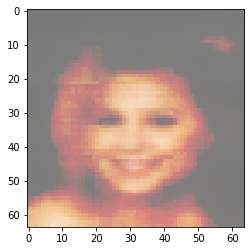

In [0]:
p = np.array([-1,-1,1]).reshape(1,3)
p = torch.from_numpy(p).float().to(device)
latent = torch.randn(1, 100).to(device)
reconstructed_img = model.decode(latent,p)
img = reconstructed_img.view(64, 64,3).cpu()
k = img.detach().numpy()
plt.imshow(k)

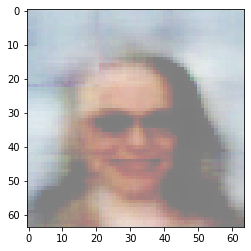

In [0]:
p = np.array([-1,1,1]).reshape(1,3)
p = torch.from_numpy(p).float().to(device)
latent = torch.randn(1, 100).to(device)
reconstructed_img = model.decode(latent,p)
img = reconstructed_img.view(64, 64,3).cpu()
k = img.detach().numpy()
plt.imshow(k)

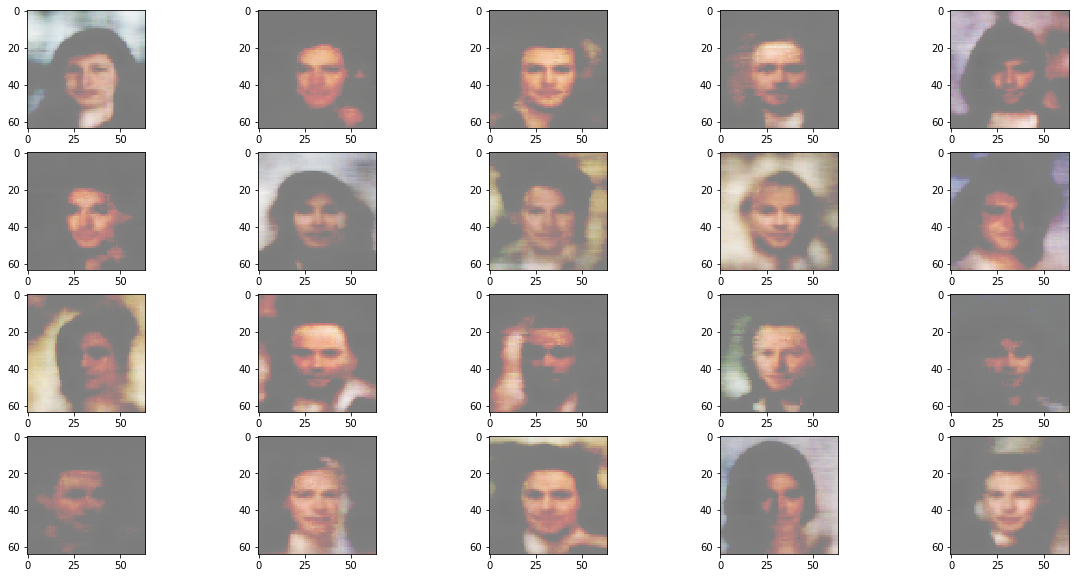

In [0]:
plt.figure(figsize=(20,10))
for j in range(20):
  p = np.array([1,-1,-1]).reshape(1,3)
  p = torch.from_numpy(p).float().to(device)
  latent = torch.randn(1, 100).to(device)
  reconstructed_img = model.decode(latent,p)

  img = reconstructed_img.view(64, 64,3).cpu()
  k = img.detach().numpy()
  plt.subplot(4,5,j+1)
  plt.imshow(k)
plt.show()

In [0]:
# from google.colab import files
# files.download("/content/save_model/0009.pt")